In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.8


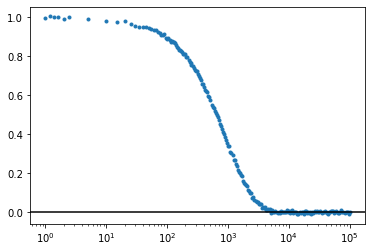

In [2]:
#### 只是为了得到实际的tau
from MultiAngleDls import multiAngleDls
filelist = ['test_data\PS_300nm_90degree.dat']
data = multiAngleDls(filelist, d_min=1, d_max=300, d_num=50)
####

tau = data.dlsDataList[0].tau * 1e-6
tau = tau.reshape((tau.size, 1))
gamma = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
gamma = gamma.reshape((1, gamma.size))
G_real = np.array([0, 0, 0.1, 0.4, 0.2, 0, 0, 0.1, 0.2, 0])  # G(gamma) is gamma distribution, real value
G_real = G_real.reshape((G_real.size, 1))

sigma = np.random.randn(tau.size, 1) * 0.005
g1square_exp = np.dot( np.exp(-np.dot(tau, gamma)), G_real)**2 + sigma

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tau*1e6, g1square_exp, '.')
ax.axhline(y=0, color='black')
ax.set_xscale('log')

In [21]:
model = pm.Model()

M = tau.size
n = G_real.size

######## 构建 prior ########
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

# second derivative operator matrix
# for prior use
L2 = np.zeros((n, n))
for j in range(L2.shape[0]-2):
    L2[j, j], L2[j, j+1], L2[j, j+2] = 1, -2, 1

# 这里试着建立一个指数分布
testG = np.ones_like(G_real) / n
testG = testG.reshape((testG.size, 1))
class prior(BoundedContinuous):
    def __init__(self, lower=np.zeros((n, 1)), L=L2, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.L = L = tt.as_tensor_variable(L)
        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is G
        lower = self.lower
        L = self.L
        return bound( -1 * tt.sum( tt.dot(L, value)**2 ), value >= lower )
#############################

###### 构建 likelihood ####### 
from pymc3.distributions import Continuous

testg1square = np.exp(-1*100*tau)**2
class likelihood(Continuous):

    def __init__(self, g1square_theo=testg1square, M=200, *args, **kwargs):
        self.g1square_theo = g1square_theo = tt.as_tensor_variable(g1square_theo)
        self.M = M = tt.as_tensor_variable(M)

        super().__init__(*args, **kwargs)

    def logp(self, value):
        # value here is g1square
        g1square_theo = self.g1square_theo
        M = self.M
        return -M/2 * tt.log( tt.sum( (value - g1square_theo)**2 ) )
#############################

with model:
    G = prior('G', lower=np.zeros_like(G_real), L=L2, shape=(n, 1), testval=testG)

    g1square_theo = tt.dot( tt.exp(-tt.dot(tau, gamma)), G)**2

    like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=g1square_exp)


In [22]:
with model:
    #step = pm.Metropolis()
    #step = pm.Slice()
    step = pm.NUTS()
    trace = pm.sample(2000, step=step, cores=1, chains=1, tune=10000, discard_tuned_samples=True)
trace['G'].shape

Sequential sampling (1 chains in 1 job)
NUTS: [G]
Sampling chain 0, 0 divergences: 100%|██████████| 12000/12000 [21:46<00:00,  9.18it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


(2000, 10, 1)

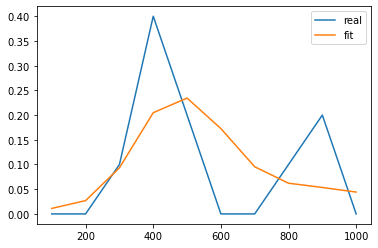

In [23]:
G_result = np.sum(trace['G'], axis=0) / (trace['G'].shape[0]+1)
#G_result
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gamma.reshape(gamma.size), G_real.reshape(G_real.size), label='real')
ax.plot(gamma.reshape(gamma.size), G_result.reshape(G_result.size), label='fit')
ax.legend()
plt.show()

In [24]:
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"G[0,0]",0.011,0.009,0.000,0.028,0.000,0.000,787.0,787.0,577.0,396.0,NaN
"G[1,0]",0.027,0.021,0.000,0.064,0.001,0.001,582.0,582.0,482.0,518.0,NaN
"G[2,0]",0.093,0.045,0.007,0.168,0.002,0.001,509.0,509.0,498.0,694.0,NaN
"G[3,0]",0.205,0.065,0.093,0.337,0.004,0.002,341.0,341.0,337.0,274.0,NaN
"G[4,0]",0.235,0.067,0.113,0.356,0.003,0.002,386.0,386.0,385.0,674.0,NaN
"G[5,0]",0.173,0.065,0.053,0.293,0.003,0.002,360.0,360.0,354.0,336.0,NaN
"G[6,0]",0.095,0.059,0.001,0.200,0.003,0.002,441.0,441.0,365.0,323.0,NaN
"G[7,0]",0.062,0.045,0.000,0.146,0.002,0.001,484.0,484.0,375.0,317.0,NaN
"G[8,0]",0.054,0.038,0.000,0.122,0.002,0.001,371.0,371.0,304.0,287.0,NaN
"G[9,0]",0.044,0.032,0.000,0.104,0.002,0.001,370.0,370.0,317.0,415.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024636B31348>,
      dtype=object)

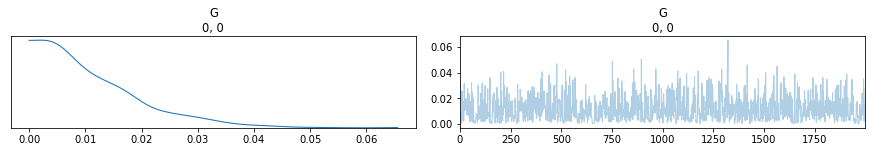

In [25]:
az.plot_trace(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000246397A7448>],
      dtype=object)

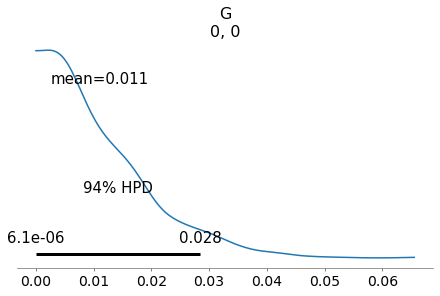

In [26]:
az.plot_posterior(trace)